# Astro (tSZ and Dust) Analysis Example:

#### <font color="blue"> by: Jeremy Meinke (feel free to contact me here on GitHub, LinkedIn, or email)
    
This details some examples for use of my other code present in analysis_code, namely:

- astro_analysis.py: A set of functions to apply to stacked mm data.

Also make sure to see the companion "fitting_example.ipynb" for description of my other code:
- func_fitting.py:  My own custom set of functions for fitting other functions.  Allows for both GLS and noteably Bayesian analysis (which I at least consider to be a pretty cool and relatively quick code).


In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from astropy.table import Table
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from pixell import enmap
from cycler import cycler
import time
import gc
import h5py

from analysis_code import general, astro_analysis

###My personal matplotlib preferences
marker_cycle=["o","^","s","d","X","2","h","v",">"]
color_cycle=["k","b","r","c","orange","m","lime","grey","lavender"]
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_cycle + color_cycle[::-1], marker=marker_cycle*2)

print("Last time run: %s"%time.asctime())

Last time run: Wed Feb  1 13:41:15 2023


We'll review some of the functions within astro_analysis.py  This includes:

- tSZ + dust function (in T_CMB units)
- Radial profile functions
- Powerlaw equations and applying stellar mass uncertainty (such as in my papers)

There are also a few functions for for subtracting the average of outer radial bins from a radial average table (when we expect the profile to go to zero at large radii).  Those are less useful to a general audience and rather simple functions, so I won't discuss them here.  Feel free, as always, to dive into any .py code itself.  I've tried to keep them in good format and documentation/comments.

--------------------------------

### Thermal Sunyaev-Zel'dovich Effect

Most of you reading this much are likely already aware of the SZ effect, such as that it arises from an inverse-compton scattering of CMB photons as they pass through hot ionized gas.
The thermal SZ effect in this manner shifts the CMB spectrum, producing a detriment of CMB photons below 217 GHz, and an excess of photons above.

When seeking to isolate the tSZ observationally however, dust from FIR wavelengths can obsure signals.  At higher redshifts, dust has an even greater impact (due to redshifting of the dust, as SZ is redshift-independent).

So let's start by plotting these signals:

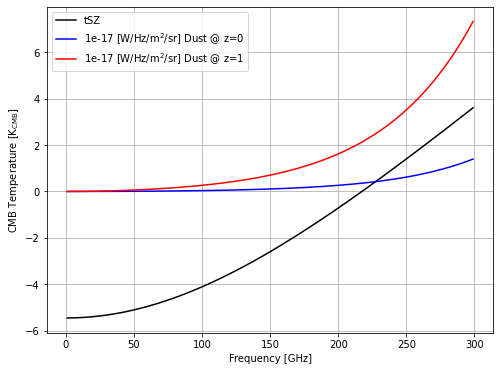

In [2]:
freqs = np.arange(1, 300)
### standard values
beta_dust = 2  ## [unitless]
t_dust = 20    ## [K]

z = 0 		   ## For now
plt.figure(figsize=(8,6))
###tSZ signal only
plt.plot(freqs, astro_analysis.tsz_dust_single_freq(freqs, z, beta_dust, t_dust, 1, 0), label="tSZ", marker="")
###1e-17 [W/Hz/m^2/sr] dust signal only (z=0)
plt.plot(freqs, astro_analysis.tsz_dust_single_freq(freqs, z, beta_dust, t_dust, 0, 1e-17), label=r"1e-17 [W/Hz/m$^2$/sr] Dust @ z=0", marker="")
###1e-17 [W/Hz/m^2/sr] dust signal only (z=1)
z = 1
plt.plot(freqs, astro_analysis.tsz_dust_single_freq(freqs, z, beta_dust, t_dust, 0, 1e-17), label=r"1e-17 [W/Hz/m$^2$/sr] Dust @ z=1", marker="")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"CMB Temperature [K$_{\rm CMB}$]")
plt.grid()
# plt.yscale("symlog")
plt.legend()
plt.show()

Thus, redshift will affect how much dust may be obsuring the tSZ signal.

Also recall from the stacking_example.ipynb we had measurements over a band.  For simplicity I'll just use SPT here.

In [3]:
###SPT Bandpasses
spt_freqs = [95, 150, 220]
spt_bp_name = "GHz_SPT_Filter.txt"
spt_bandpasses = [np.genfromtxt("./data/" + str(f) + spt_bp_name) for f in spt_freqs]
print(spt_bandpasses[1].shape)
### For passing through fitting functions, each frequency bandpass would need to be the same size.  You can do this by filling zeros at their uppermost frequency
maxlen=max([len(i) for i in spt_bandpasses])
for i in range(3):
	# while len(spt_bandpass[i])<maxlen:
	# 	spt_bandpass[i]=np.vstack((spt_bandpass[i],spt_bandpass[i][-1,:]))
	bp_len=len(spt_bandpasses[i])
	print("SPT %iGHz old len: "%spt_freqs[i], bp_len)	###notice how they're different lengths to start with
	if bp_len < maxlen:
		extra=np.column_stack([spt_bandpasses[i][-1,0]+np.arange(maxlen-bp_len)+1,np.zeros(maxlen-bp_len)])
		# print(extra[-10:,:])
		spt_bandpasses[i]=np.vstack([spt_bandpasses[i],extra])
	print("new len: ", len(spt_bandpasses[i]))
### Though technically not needed for what I'm showing here...

print("-----------------")
for f in range(3):
	print("SPT %iGHz"%spt_freqs[f])
	###tSZ Only
	print("tSZ: ", astro_analysis.tsz_dust_over_band(spt_bandpasses[f].T, 0, beta_dust, t_dust, 1, 0))
	###Dust @ z=0
	print("1e-17 Dust @ z=0: ", astro_analysis.tsz_dust_over_band(spt_bandpasses[f].T, 0, beta_dust, t_dust, 0, 1e-17))
	###Dust @ z=1
	print("1e-17 Dust @ z=1: ", astro_analysis.tsz_dust_over_band(spt_bandpasses[f].T, 1, beta_dust, t_dust, 0, 1e-17))
	print("-----------------")

(71, 2)
SPT 95GHz old len:  99
new len:  99
SPT 150GHz old len:  71
new len:  99
SPT 220GHz old len:  62
new len:  99
-----------------
SPT 95GHz
tSZ:  -4.128800390339944
1e-17 Dust @ z=0:  0.035883625131188555
1e-17 Dust @ z=1:  0.2527782052712486
-----------------
SPT 150GHz
tSZ:  -2.462761741821359
1e-17 Dust @ z=0:  0.11767005681195719
1e-17 Dust @ z=1:  0.7660562368515398
-----------------
SPT 220GHz
tSZ:  0.11068778049994359
1e-17 Dust @ z=0:  0.3839726777490611
1e-17 Dust @ z=1:  2.2666773192353484
-----------------


Thus, we can see that averaging over the SPT 220GHz band yields a faint positive tSZ, while the other two bands are significantly negative, as expected.

Now, say we have already obtained or fit data to such a spectrum, and want to convert an integrated tSZ (compton-y) or dust over a solid angle to Janskies (or mJy in most cases).

For z~1 individual galaxies, our recent results showed reasonable values of tSZ were ~2e-5 [arcmin^2] and dust (353 GHz rest frame) was upwards of 4e-22 [W/Hz/m^2/sr * arcmin^2]:

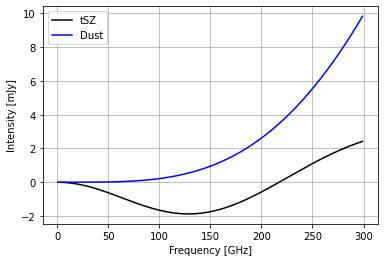

In [4]:
tSZ_y = 2e-5
dust_intensity = 4e-22

###arcmin=True here to convert to steradians solid angle
plt.plot(freqs, astro_analysis.y_to_mJy(freqs, tSZ_y, arcmin=True), label="tSZ", marker="")
plt.plot(freqs, astro_analysis.dust_intensity_to_mJy(freqs, dust_intensity, t_dust, beta_dust, z=1, arcmin=True), label="Dust", marker="")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Intensity [mJy]")
plt.legend()
plt.grid()
plt.show()

### Radial Profiles

Now to briefly go over radial profiles.  Our upcoming paper (under review) has a detailed description of what profiles we sought to fit.  Most pertain to a point source plus King profile model.

The point source is simply one that corresponds to our instrument's beam, while the unprojected King profile is defined as either: 
- k(r)=A_k*(1+(r/r_0)^2)^(-3*slope/2) or
- k(r)=A_k*(1+(r/r_0)^2)^(-slope)

Give or take constants in front (we divide by a further r_0 in front to make the projected profile easier).  By projected, we mean through the line-of-sight, as we're viewing a 2D image of a galaxy halo which, on average, should be a roughly spherically symmetric 3D profile.  Further complicating things is the beam again, which is convolved with this profile.

In plot form, we have:

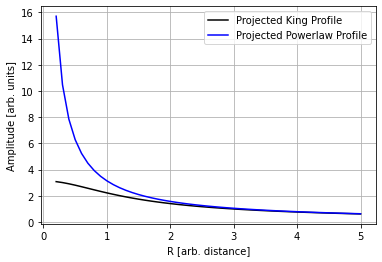

In [5]:
###Projected (not convolved yet) profile:
rs = np.arange(0.2, 5.01, .1)	###arb. distance units
r_0 = 1
slope = 2
a_k = a_pl = 1
plt.plot(rs, astro_analysis.proj_king(rs, r_0, slope, a_k, slope_like_powerlaw=True), label="Projected King Profile", marker="")
plt.plot(rs, astro_analysis.proj_powerlaw(rs, r_0, slope, a_pl), label="Projected Powerlaw Profile", marker="")
plt.xlabel("R [arb. distance]")
plt.ylabel("Amplitude [arb. units]")
plt.legend()
plt.grid()
plt.show()

Note how the two are very similar far from r_0=1, but diverge from another below it. (And the powerlaw diverges to inf as it approaches zero)

However, such data is also going to be convolved with a beam.  For mm data, this is often in the range of 1-10 arcminutes FWHM.  We also have functions that factor this into the profile.

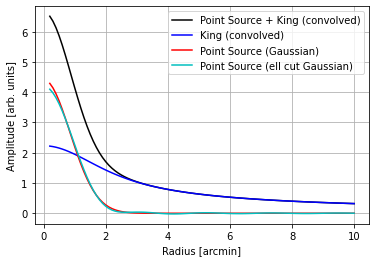

In [6]:
###Projected and convolved with the beam, now distance matters as the functions take angular inputs
thetas = np.arange(0.2, 10.01, 0.1)
z = 1
beam_fwhm = 2
a_ps = 20
plt.plot(thetas, astro_analysis.proj_ptsrc_king_convolved(thetas, z, r_0, slope, a_k, a_ps, beam_fwhm, c=0), label="Point Source + King (convolved)", marker="")
plt.plot(thetas, astro_analysis.proj_king_convolved(thetas, z, r_0, slope, a_k, beam_fwhm), label="King (convolved)", marker="")
plt.plot(thetas, astro_analysis.proj_ptsrc_convolved(thetas, a_ps, beam_fwhm), label="Point Source (Gaussian)", marker="")
###Note slight differences between these (beam_lmax cut here to affect our point source) (This option isn't currently built into the King profile, since it is affected less)
plt.plot(thetas, astro_analysis.proj_ptsrc_convolved(thetas, a_ps, beam_fwhm, beam_lmax=10000), label="Point Source (ell cut Gaussian)", marker="")
plt.xlabel("Radius [arcmin]")
plt.ylabel("Amplitude [arb. units]")
plt.legend()
plt.grid()
plt.show()

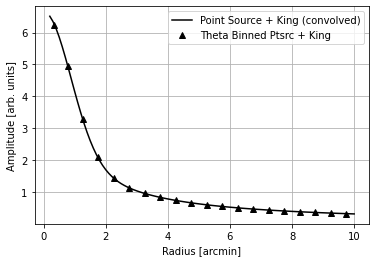

In [7]:
###For fitting radial averages measured in radial bins, we have similar functions:
theta_edges = np.arange(0., 10.01, 0.5)
theta_centers = 2 / 3 * (theta_edges[1:]**3 - theta_edges[:-1]**3) / (theta_edges[1:]**2 - theta_edges[:-1]**2)	###True radial center between edges (since 2d radius)
plt.plot(thetas, astro_analysis.proj_ptsrc_king_convolved(thetas, z, r_0, slope, a_k, a_ps, beam_fwhm, c=0, slope_like_powerlaw=True), label="Point Source + King (convolved)", marker="")
plt.plot(theta_centers, astro_analysis.proj_angular_avg_ptsrc_king_convolved(np.asarray([theta_edges[:-1], theta_edges[1:]]), z, r_0, slope, a_k, a_ps, beam_fwhm, slope_like_powerlaw=True), label="Theta Binned Ptsrc + King", color=color_cycle[0], linestyle="")

###Option to see how beam_lmax cut would affect the point source component of binned profile
# plt.plot(theta_centers, astro_analysis.proj_angular_avg_ptsrc_king_convolved(np.asarray([theta_edges[:-1], theta_edges[1:]]), z, r_0, slope, a_k, a_ps, beam_fwhm, slope_like_powerlaw=True, beam_lmax=10000), label="Theta Binned Ptsrc + King beam_lmax=10000", color=color_cycle[0], linestyle="")

plt.xlabel("Radius [arcmin]")
plt.ylabel("Amplitude [arb. units]")
plt.legend()
plt.grid()
plt.show()


(Angular distance can be converted to comoving distance via astropy.cosomology's LambdaCDM(...).comoving_transverse_distance() )

## ----- vs Stellar Mass Powerlaw Relation (with Stellar Mass Uncertainty)

I specifically used this method for both Thermal Energy and Dust Mass vs Stellar Mass Powerlaw functions (see our papers for more details).

For this example, I'll simply stick to "Energy" vs Stellar Mass, but this can easily be substituted with another value you seek to inspect against stellar mass.
We write the relation as a powerlaw, easiest in our case as a log-log or log-linear:

log10(E) = log10(E_pk) + alpha * (log10(mass) - log10(mass_pk))

So it's example and plotting time!

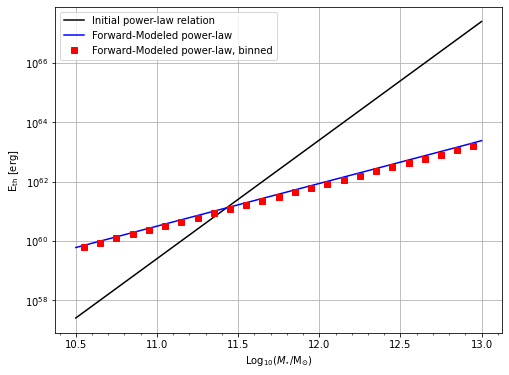

In [8]:
## First let's define a basic powerlaw relation to plot for a range of log_mass 
# (and somewhat close to our measurements)
log_masses = np.arange(10.5, 13.01, 0.1)
log_mass_pk = 11.4
alpha = 4
energy_pk = 10**(61.)

plt.figure(figsize=(8,6))
plt.plot(log_masses, astro_analysis.xlog_y_pl(log_masses, log_mass_pk, energy_pk, alpha), label="Initial power-law relation", marker="")
## However, observationally we have stellar mass uncertainty that can affect this relation, 
# For a galaxy stellar mass distribution like ours, narrowly distributed around 11.4 dex fit with gaussian sigma of approx 0.2, but stellar mass uncertainty of 0.16 dex 
sed_sigma = 0.16
mass_distr_sigma = 0.20
plt.plot(log_masses, astro_analysis.powerlaw_mass_correction_by_convolving(log_masses, energy_pk, alpha, sed_sigma, mass_distr_sigma, log_mass_pk, pl_lin=True), label="Forward-Modeled power-law", marker="") 
## notice how much flatter it is now (all due to the stellar mass uncertainty and narrow mass distribution),

## so if binned by 0.1 dex stellar mass bins:
mbin_width = 0.1
log_mbin_centers = np.arange(10.55, 13.01, mbin_width)
plt.plot(log_mbin_centers, astro_analysis.powerlaw_mass_correction_mbinned(log_mbin_centers, mbin_width, energy_pk, alpha, sed_sigma, mass_distr_sigma, log_mass_pk, pl_lin=True), label="Forward-Modeled power-law, binned", linestyle="")
## This would be the function to fit actual binned measurements/observations

plt.xlabel(r"Log$_{10}(M_{\star} / \rm{M}_{\odot})$")
plt.ylabel(r"$\rm{E}_{th}$ [erg]")
plt.yscale("log")
plt.minorticks_on()
plt.legend()
plt.grid()
plt.show()

This concludes the review of mm-stacking analysis functions in present in astro_analysis.py

Now, there are a few functions I didn't directly showcase and other uses for those that I did show, so I encourage those curious to just dig through the file itself and make any personal additions/modifications they wish.

Please see the separate *fitting_example.ipynb* for further discussion about my generalized fitting function and its uses with such functions shown here.